# Dynamic Conversational Coherence Metric

Reference implementation of the dynamic conversational coherence metric C(t) introduced in:

Adolfo J. Céspedes Jiménez (2026)  
"A Minimal Metric for Dynamic Conversational Coherence"

This notebook is fully reproducible and Google Colab–compatible.


Note: The dataset is used for illustration only. The metric itself is dataset-agnostic.


In [1]:
!pip -q install "datasets<4"
!pip -q install --upgrade pip
!pip -q install -U sentence-transformers scikit-learn pandas matplotlib

In [2]:
import os, random, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset
from sentence_transformers import SentenceTransformer

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

os.environ["HF_HUB_DISABLE_TELEMETRY"] = "1"


In [3]:
dataset = load_dataset("empathetic_dialogues")
print(dataset)
print("Train size:", len(dataset["train"]))
print("Example keys:", dataset["train"][0].keys())


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['conv_id', 'utterance_idx', 'context', 'prompt', 'speaker_idx', 'utterance', 'selfeval', 'tags'],
        num_rows: 76673
    })
    validation: Dataset({
        features: ['conv_id', 'utterance_idx', 'context', 'prompt', 'speaker_idx', 'utterance', 'selfeval', 'tags'],
        num_rows: 12030
    })
    test: Dataset({
        features: ['conv_id', 'utterance_idx', 'context', 'prompt', 'speaker_idx', 'utterance', 'selfeval', 'tags'],
        num_rows: 10943
    })
})
Train size: 76673
Example keys: dict_keys(['conv_id', 'utterance_idx', 'context', 'prompt', 'speaker_idx', 'utterance', 'selfeval', 'tags'])


In [4]:
def build_dialogs_from_empathetic(ds, split="train"):
    dialogs = []
    current = []
    current_conv = None

    for row in ds[split]:
        if row["conv_id"] != current_conv:
            if current:
                dialogs.append({"dialog": current, "conv_id": current_conv})
            current = []
            current_conv = row["conv_id"]

        current.append(row["utterance"])

    if current:
        dialogs.append({"dialog": current, "conv_id": current_conv})

    return dialogs

dialogs_all = build_dialogs_from_empathetic(dataset, split="train")
lengths = [len(d["dialog"]) for d in dialogs_all]
print("Total dialogs:", len(dialogs_all))
print("Length stats: min", min(lengths), "mean", round(np.mean(lengths),2), "max", max(lengths))


Total dialogs: 17844
Length stats: min 1 mean 4.3 max 8


In [5]:
dialogs = dialogs_all[:200]

In [6]:
model = SentenceTransformer("all-MiniLM-L6-v2")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [7]:
def embed_dialog(dialog):
    return model.encode(dialog, normalize_embeddings=True)

def dynamic_coherence(embeddings, alpha=0.7, eps=1e-12):
    C = []
    memory = embeddings[0].copy()
    for t in range(1, len(embeddings)):
        C.append(float(np.dot(embeddings[t], memory)))
        memory = alpha * memory + (1 - alpha) * embeddings[t]
        n = float(np.linalg.norm(memory))
        memory = memory / max(n, eps)
    return np.array(C, dtype=float)

def local_similarity(embeddings):
    return np.array([float(np.dot(embeddings[t], embeddings[t-1])) for t in range(1, len(embeddings))], dtype=float)

def detect_breaks_topk(signal, p=10, min_k=0, max_k=None):
    """
    Detecta rupturas como las k peores caídas de ΔC.
    k = ceil(p% * n_deltas), acotado por [min_k, max_k] si se da.
    Permite k=0 si min_k=0 y el diálogo es demasiado corto o si quieres permitir 'sin rupturas'.
    """
    delta = np.diff(signal)
    n = len(delta)
    if n <= 0:
        return np.array([], dtype=int), np.nan, delta

    k = math.ceil((p/100) * n)
    if max_k is not None:
        k = min(k, max_k)
    k = max(min_k, k)

    if k == 0:
        return np.array([], dtype=int), np.nan, delta

    idx = np.argsort(delta)[:k]              # k deltas más negativos
    breaks = np.sort(idx + 1)                # +1 para mapear a índice en la señal
    thr = float(delta[idx[-1]])              # umbral implícito: k-ésimo peor
    return breaks, thr, delta

def shuffle_dialog(dialog, seed=42):
    rng = random.Random(seed)
    shuffled = dialog.copy()
    rng.shuffle(shuffled)
    return shuffled


In [8]:
results = []

ALPHA = 0.7
P_BREAK = 10
MIN_K = 0           # permite 0 rupturas si quieres (recomendado)
MAX_K = 3           # cap para no marcar demasiadas en diálogos medianos (ajustable)

for i, d in enumerate(dialogs):
    dialog = d["dialog"]
    n_turns = len(dialog)

    # Real
    emb = embed_dialog(dialog)
    C_dyn = dynamic_coherence(emb, alpha=ALPHA)
    C_base = local_similarity(emb)
    breaks, thr, delta = detect_breaks_topk(C_dyn, p=P_BREAK, min_k=MIN_K, max_k=MAX_K)

    # Control shuffled (mismo contenido, orden aleatorio)
    dialog_sh = shuffle_dialog(dialog, seed=SEED + i)
    emb_sh = embed_dialog(dialog_sh)
    C_dyn_sh = dynamic_coherence(emb_sh, alpha=ALPHA)
    C_base_sh = local_similarity(emb_sh)
    breaks_sh, thr_sh, delta_sh = detect_breaks_topk(C_dyn_sh, p=P_BREAK, min_k=MIN_K, max_k=MAX_K)

    # Métricas agregadas (pero derivadas de señal dinámica)
    def safe_corr(a, b):
        if len(a) < 2 or len(b) < 2:
            return np.nan
        return float(np.corrcoef(a, b)[0,1])

    row = {
        "dialog_id": i,
        "conv_id": d.get("conv_id", None),
        "n_turns": n_turns,

        # Señales (para inspección / figuras)
        "C_dyn": C_dyn.tolist(),
        "C_base": C_base.tolist(),
        "delta_C_dyn": delta.tolist(),
        "break_positions": breaks.tolist(),
        "break_threshold_delta": thr,
        "n_breaks": int(len(breaks)),

        # Resúmenes real
        "mean_Cdyn": float(np.mean(C_dyn)),
        "mean_Cbase": float(np.mean(C_base)),
        "auc_Cdyn": float(np.sum(C_dyn)),
        "vol_Cdyn": float(np.std(C_dyn)),
        "vol_Cbase": float(np.std(C_base)),
        "corr_dyn_base": safe_corr(C_dyn, C_base),

        # Control shuffled (resúmenes)
        "mean_Cdyn_sh": float(np.mean(C_dyn_sh)),
        "mean_Cbase_sh": float(np.mean(C_base_sh)),
        "auc_Cdyn_sh": float(np.sum(C_dyn_sh)),
        "vol_Cdyn_sh": float(np.std(C_dyn_sh)),
        "vol_Cbase_sh": float(np.std(C_base_sh)),
        "corr_dyn_base_sh": safe_corr(C_dyn_sh, C_base_sh),
        "n_breaks_sh": int(len(breaks_sh)),

        # Diferencias (lo que quieres mostrar en Results)
        "d_mean_Cdyn": float(np.mean(C_dyn) - np.mean(C_dyn_sh)),
        "d_auc_Cdyn": float(np.sum(C_dyn) - np.sum(C_dyn_sh)),
        "d_vol_Cdyn": float(np.std(C_dyn) - np.std(C_dyn_sh)),
        "d_n_breaks": int(len(breaks) - len(breaks_sh)),
    }

    results.append(row)

df = pd.DataFrame(results)
df.head()


/usr/local/lib/python3.12/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.12/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.12/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.12/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,dialog_id,conv_id,n_turns,C_dyn,C_base,delta_C_dyn,break_positions,break_threshold_delta,n_breaks,mean_Cdyn,...,mean_Cbase_sh,auc_Cdyn_sh,vol_Cdyn_sh,vol_Cbase_sh,corr_dyn_base_sh,n_breaks_sh,d_mean_Cdyn,d_auc_Cdyn,d_vol_Cdyn,d_n_breaks
0,0,hit:0_conv:1,6,"[0.5765180587768555, 0.41606688499450684, 0.24...","[0.5765180587768555, 0.424114853143692, 0.4470...","[-0.16045117378234863, -0.16781267523765564, 0...",[4],-0.193063,1,0.367523,...,0.249069,1.623863,0.161418,0.126781,0.966782,1,0.042751,0.213754,-0.028409,0
1,1,hit:1_conv:2,6,"[0.1510351002216339, 0.349183052778244, 0.5564...","[0.1510351002216339, 0.18689531087875366, 0.18...","[0.1981479525566101, 0.20731058716773987, -0.3...",[3],-0.357720,1,0.310978,...,0.275922,1.428425,0.226573,0.198921,0.963635,1,0.025293,0.126464,-0.085121,0
2,2,hit:1_conv:3,5,"[0.6476292610168457, 0.1773386001586914, 0.036...","[0.6476292610168457, 0.2673998475074768, 0.146...","[-0.4702906608581543, -0.14084453508257866, 0....",[1],-0.470291,1,0.319475,...,0.130005,1.289285,0.165063,0.109084,0.503817,1,-0.002847,-0.011387,0.068050,0
3,3,hit:2_conv:4,4,"[0.28377753496170044, 0.19047734141349792, 0.5...","[0.28377753496170044, 0.069954052567482, 0.538...","[-0.09330019354820251, 0.36460402607917786]",[1],-0.093300,1,0.343112,...,0.207293,1.025021,0.079758,0.172367,0.940997,1,0.001438,0.004315,0.074891,0
4,4,hit:2_conv:5,5,"[0.18139144778251648, 0.33454757928848267, 0.3...","[0.18139144778251648, 0.45671969652175903, 0.2...","[0.1531561315059662, -0.0010411739349365234, -...",[3],-0.090618,1,0.273083,...,0.247748,1.371670,0.091463,0.123182,0.647896,1,-0.069834,-0.279336,-0.026756,0


In [9]:
print("N dialogs:", len(df))
print("\n=== REAL vs SHUFFLED (promedios) ===")
print("mean_Cdyn:", df["mean_Cdyn"].mean(), " | shuffled:", df["mean_Cdyn_sh"].mean())
print("auc_Cdyn:", df["auc_Cdyn"].mean(),   " | shuffled:", df["auc_Cdyn_sh"].mean())
print("vol_Cdyn:", df["vol_Cdyn"].mean(),   " | shuffled:", df["vol_Cdyn_sh"].mean())
print("n_breaks:", df["n_breaks"].mean(),   " | shuffled:", df["n_breaks_sh"].mean())

print("\n=== DIFERENCIAS (real - shuffled) ===")
print("d_mean_Cdyn mean:", df["d_mean_Cdyn"].mean())
print("d_auc_Cdyn  mean:", df["d_auc_Cdyn"].mean())
print("d_vol_Cdyn  mean:", df["d_vol_Cdyn"].mean())
print("d_n_breaks  mean:", df["d_n_breaks"].mean())

print("\n% diálogos con d_auc_Cdyn > 0:", (df["d_auc_Cdyn"] > 0).mean())


N dialogs: 200

=== REAL vs SHUFFLED (promedios) ===
mean_Cdyn: 0.3552587797292193  | shuffled: 0.34819041288906427
auc_Cdyn: 1.2621427885955199  | shuffled: 1.235728998966515
vol_Cdyn: 0.11257999094807422  | shuffled: 0.11270913187615572
n_breaks: 0.995  | shuffled: 0.995

=== DIFERENCIAS (real - shuffled) ===
d_mean_Cdyn mean: 0.007068366840155049
d_auc_Cdyn  mean: 0.026413789629004897
d_vol_Cdyn  mean: -0.00012914092808148124
d_n_breaks  mean: 0.0

% diálogos con d_auc_Cdyn > 0: 0.58


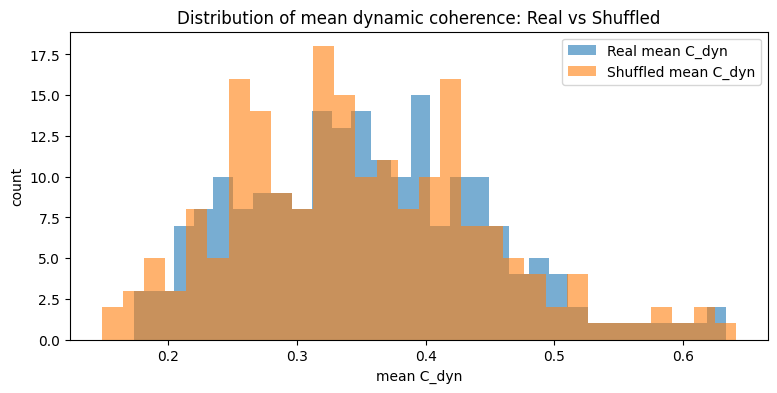

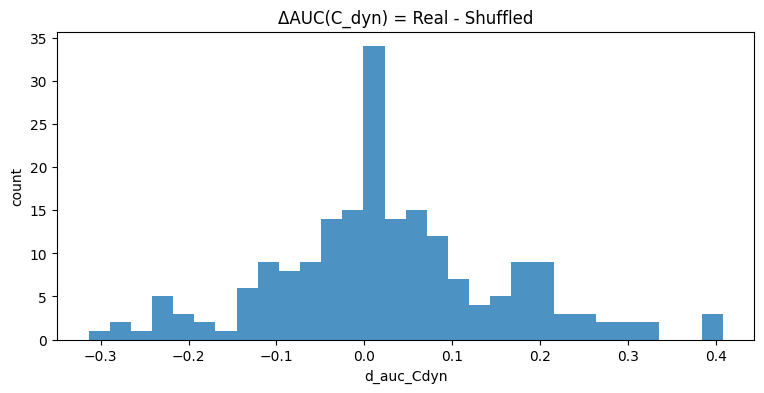

In [10]:
plt.figure(figsize=(9,4))
plt.hist(df["mean_Cdyn"], bins=30, alpha=0.6, label="Real mean C_dyn")
plt.hist(df["mean_Cdyn_sh"], bins=30, alpha=0.6, label="Shuffled mean C_dyn")
plt.title("Distribution of mean dynamic coherence: Real vs Shuffled")
plt.xlabel("mean C_dyn")
plt.ylabel("count")
plt.legend()
plt.show()

plt.figure(figsize=(9,4))
plt.hist(df["d_auc_Cdyn"], bins=30, alpha=0.8)
plt.title("ΔAUC(C_dyn) = Real - Shuffled")
plt.xlabel("d_auc_Cdyn")
plt.ylabel("count")
plt.show()


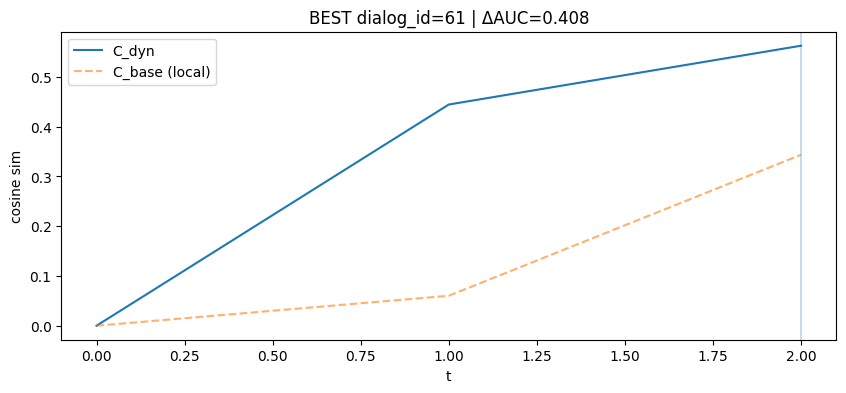

Dialog text:
00: Did you go outside and see if anyone was hurt?
01: What do you mean? I don't know what you are talking about.
02: I heard a noise outside that sounded like a car had wrecked yesterday.
03: Well then I guess you should have went and checked to see if anyone was hurt. I hope you called a ambulance.
Break positions: [2]


In [11]:
def plot_dialog_signals(C_dyn, C_base, breaks, title=""):
    plt.figure(figsize=(10,4))
    plt.plot(C_dyn, label="C_dyn")
    plt.plot(C_base, "--", alpha=0.6, label="C_base (local)")
    for b in breaks:
        plt.axvline(b, alpha=0.25)
    plt.title(title)
    plt.xlabel("t")
    plt.ylabel("cosine sim")
    plt.legend()
    plt.show()

# Selecciona el dialogo con mayor ΔAUC
best_id = int(df.sort_values("d_auc_Cdyn", ascending=False).iloc[0]["dialog_id"])
d = dialogs[best_id]

# Recalcula señales para plot (o usa las guardadas)
C_dyn = np.array(df.loc[df.dialog_id==best_id, "C_dyn"].values[0])
C_base = np.array(df.loc[df.dialog_id==best_id, "C_base"].values[0])
breaks = np.array(df.loc[df.dialog_id==best_id, "break_positions"].values[0])

plot_dialog_signals(C_dyn, C_base, breaks, title=f"BEST dialog_id={best_id} | ΔAUC={df.loc[df.dialog_id==best_id,'d_auc_Cdyn'].values[0]:.3f}")

print("Dialog text:")
for t, utt in enumerate(d["dialog"]):
    print(f"{t:02d}: {utt}")
print("Break positions:", breaks.tolist())


In [12]:
df.to_csv("dynamic_coherence_results_scaled_with_shuffle.csv", index=False)

from google.colab import files
files.download("dynamic_coherence_results_scaled_with_shuffle.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>